### Notebook for testing goals scored per match in different leagues

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

In [3]:
c.execute('''SELECT * FROM League ''')

league = pd.DataFrame(c.fetchall())
league.columns = [i[0] for i in c.description]

In [4]:
#league information
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [5]:
#join matches and leagues to pair matches and league information
c.execute('''
            SELECT 
                   m.id,
                   l.name as league,
                   l.id as league_id,
                   m.season,
                   m.date,
                   m.match_api_id,
                   m.home_team_api_id,
                   m.away_team_api_id,
                   m.home_team_goal,
                   m.away_team_goal
            FROM Match m
            LEFT JOIN League l ON (m.league_id = l.id)
                                   
            ;''')

match_league = pd.DataFrame(c.fetchall())
match_league.columns = [i[0] for i in c.description]

In [6]:
match_league.head()

,id,league,league_id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,Belgium Jupiler League,1,2008/2009,2008-08-17 00:00:00,492473,9987,9993,1,1
1,2,Belgium Jupiler League,1,2008/2009,2008-08-16 00:00:00,492474,10000,9994,0,0
2,3,Belgium Jupiler League,1,2008/2009,2008-08-16 00:00:00,492475,9984,8635,0,3
3,4,Belgium Jupiler League,1,2008/2009,2008-08-17 00:00:00,492476,9991,9998,5,0
4,5,Belgium Jupiler League,1,2008/2009,2008-08-16 00:00:00,492477,7947,9985,1,3


In [7]:
#get relevant leagues
match_league_v2 = match_league.query('league_id == 1 | league_id == 13274 | league_id == 15722 \
                                  | league_id == 17642 | league_id == 19694 | league_id == 24558')

In [8]:
match_league_v2 = match_league_v2[['id', 'league', 'season', 'date', 'home_team_goal', 'away_team_goal']]

In [9]:
match_league_v2['total_goals'] = match_league_v2['home_team_goal'] + match_league_v2['away_team_goal']

In [10]:
match_league_v2.head()

,id,league,season,date,home_team_goal,away_team_goal,total_goals
0,1,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,1,1,2
1,2,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,0,0,0
2,3,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,0,3,3
3,4,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,5,0,5
4,5,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,1,3,4


In [11]:
match_league_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11394 entries, 0 to 25978
Data columns (total 7 columns):
id                11394 non-null int64
league            11394 non-null object
season            11394 non-null object
date              11394 non-null object
home_team_goal    11394 non-null int64
away_team_goal    11394 non-null int64
total_goals       11394 non-null int64
dtypes: int64(4), object(3)
memory usage: 712.1+ KB


In [12]:
#preview summary statistics by league and by season
#match_league_v2.groupby(['league', 'season']).describe()['total_goals']

In [13]:
#dropping belgium league season 2013/2014 due to lack of data
match_league_v2 = match_league_v2.loc[~((match_league_v2['league'] == 'Belgium Jupiler League') & 
                     (match_league_v2['season']=='2013/2014'))]

In [14]:
#preview summary stats by league, note Dutch league has highest mean goals scored per match
match_league_v2.groupby(['league']).describe()['total_goals']

,count,mean,std,min,25%,50%,75%,max
league,,,,,,,,
Belgium Jupiler League,1716.0,2.803613,1.654892,0.0,2.0,3.0,4.0,9.0
Netherlands Eredivisie,2448.0,3.080882,1.740640,0.0,2.0,3.0,4.0,10.0
Poland Ekstraklasa,1920.0,2.425000,1.540355,0.0,1.0,2.0,3.0,8.0
Portugal Liga ZON Sagres,2052.0,2.534600,1.637348,0.0,1.0,2.0,4.0,9.0
Scotland Premier League,1824.0,2.633772,1.644379,0.0,1.0,2.0,4.0,12.0
Switzerland Super League,1422.0,2.929677,1.717765,0.0,2.0,3.0,4.0,9.0


In [15]:
match_league_v2.groupby(['league', 'season']).describe()['total_goals']

count      mean       std  min   25%  50%  \
league                   season                                                 
Belgium Jupiler League   2008/2009  306.0  2.794118  1.599210  0.0  2.00  3.0   
                         2009/2010  210.0  2.690476  1.468784  0.0  2.00  2.0   
                         2010/2011  240.0  2.645833  1.657866  0.0  1.00  2.0   
                         2011/2012  240.0  2.879167  1.803641  0.0  2.00  3.0   
                         2012/2013  240.0  2.929167  1.733012  0.0  2.00  3.0   
                         2014/2015  240.0  2.783333  1.704944  0.0  2.00  3.0   
                         2015/2016  240.0  2.891667  1.588641  0.0  2.00  3.0   
Netherlands Eredivisie   2008/2009  306.0  2.843137  1.742874  0.0  2.00  3.0   
                         2009/2010  306.0  2.915033  1.755358  0.0  2.00  3.0   
                         2010/2011  306.0  3.225490  1.856704  0.0  2.00  3.0   
                         2011/2012  306.0  3.258170  1.770991  0.0  2.00  3.0   
                         2012/2013  306.0  3.150327  1.762157  0.0  2.00  3.0   
                         2013/2014  306.0  3.196078  1.619791  0.0  2.00  3.0   
                         2014/2015  306.0  3.078431  1.738774  0.0  2.00  3.0   
                         2015/2016  306.0  2.980392  1.639554  0.0  2.00  3.0   
Poland Ekstraklasa       2008/2009  240.0  2.183333  1.405210  0.0  1.00  2.0   
                         2009/2010  240.0  2.216667  1.487371  0.0  1.00  2.0   
                         2010/2011  240.0  2.408333  1.610612  0.0  1.00  2.0   
                         2011/2012  240.0  2.195833  1.443201  0.0  1.00  2.0   
                         2012/2013  240.0  2.491667  1.414189  0.0  1.75  2.0   
                         2013/2014  240.0  2.641667  1.645564  0.0  1.75  2.0   
                         2014/2015  240.0  2.616667  1.553419  0.0  2.00  3.0   
                         2015/2016  240.0  2.645833  1.665420  0.0  2.00  2.0   
Portugal Liga ZON Sagres 2008/2009  240.0  2.300000  1.566383  0.0  1.00  2.0   
                         2009/2010  240.0  2.504167  1.801900  0.0  1.00  2.0   
                         2010/2011  240.0  2.433333  1.640152  0.0  1.00  2.0   
                         2011/2012  240.0  2.641667  1.688236  0.0  1.00  3.0   
                         2012/2013  240.0  2.779167  1.632945  0.0  2.00  3.0   
                         2013/2014  240.0  2.370833  1.457911  0.0  1.00  2.0   
                         2014/2015  306.0  2.493464  1.539094  0.0  1.00  2.0   
                         2015/2016  306.0  2.715686  1.712313  0.0  1.00  3.0   
Scotland Premier League  2008/2009  228.0  2.403509  1.506048  0.0  1.00  2.0   
                         2009/2010  228.0  2.565789  1.805539  0.0  1.00  2.0   
                         2010/2011  228.0  2.561404  1.469425  0.0  2.00  2.0   
                         2011/2012  228.0  2.635965  1.772011  0.0  1.00  2.0   
                         2012/2013  228.0  2.732456  1.751877  0.0  1.00  3.0   
                         2013/2014  228.0  2.745614  1.630175  0.0  2.00  3.0   
                         2014/2015  228.0  2.574561  1.456767  0.0  1.00  2.5   
                         2015/2016  228.0  2.850877  1.703753  0.0  2.00  3.0   
Switzerland Super League 2008/2009  180.0  3.000000  1.803163  0.0  2.00  3.0   
                         2009/2010  180.0  3.327778  1.742760  0.0  2.00  3.0   
                         2010/2011  180.0  2.983333  1.587222  0.0  2.00  3.0   
                         2011/2012  162.0  2.623457  1.694036  0.0  1.00  2.0   
                         2012/2013  180.0  2.566667  1.568189  0.0  1.75  2.0   
                         2013/2014  180.0  2.888889  1.630330  0.0  2.00  3.0   
                         2014/2015  180.0  2.872222  1.797051  0.0  1.00  3.0   
                         2015/2016  180.0  3.144444  1.803542  0.0  2.00  3.0   

                                     75%   max  
league           

In [16]:
#assumption - different leagues are different population with different means and variances
#null hypothesis - there is no differences between average goals scored per match in the Dutch league and the other leagues
#alternative hypothesis - statistically there are more goals scored per match in the Dutch league than the other leagues 
#alpha level = 0.05
#use one tail welch t-test

In [17]:
#extract goal information for each league
bel_goals = np.array(match_league_v2.loc[match_league_v2['league']=='Belgium Jupiler League']['total_goals'])
ned_goals = np.array(match_league_v2.loc[match_league_v2['league']=='Netherlands Eredivisie']['total_goals'])
pol_goals = np.array(match_league_v2.loc[match_league_v2['league']=='Poland Ekstraklasa']['total_goals'])
prt_goals = np.array(match_league_v2.loc[match_league_v2['league']=='Portugal Liga ZON Sagres']['total_goals'])
sct_goals = np.array(match_league_v2.loc[match_league_v2['league']=='Scotland Premier League']['total_goals'])
sui_goals = np.array(match_league_v2.loc[match_league_v2['league']=='Switzerland Super League']['total_goals'])

In [18]:
#comparison NED vs SUI
t, p = stats.ttest_ind(ned_goals, sui_goals, equal_var=False)
p/2
#Null hypothesis rejected

0.004327737916030082

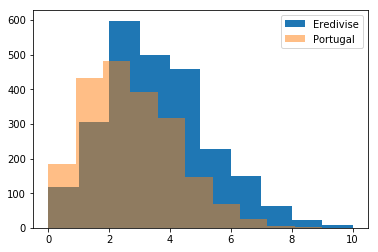

In [19]:
plt.hist(ned_goals, label='Eredivise');
plt.hist(prt_goals, label='Portugal', alpha=0.5);
plt.legend();

In [20]:
def bootstrap(x, y, size=1000):

    n = size

    x_bs_size = int(len(x)*0.8)
    y_bs_size = int(len(y)*0.8)

    x_bs_samples = []
    y_bs_samples = []
    
    x_bs_means = np.zeros(n)
    y_bs_means = np.zeros(n)

    for i in range(n):
        x_bs_samples = np.random.choice(x, size=x_bs_size)
        y_bs_samples = np.random.choice(y, size=y_bs_size)
        #jp_bootstrap.append(jp_bootstrap)
        #usa_bootstrap.append(bootstrap_sample(usa_bootstrap))
        x_bs_means[i] = (x_bs_samples.mean())
        y_bs_means[i] = (y_bs_samples.mean())
    
    p = 1-sum((x_bs_means - y_bs_means)>0)/n

    plt.hist(x_bs_means, label='X');
    plt.hist(y_bs_means, label='Y');
    plt.title('Bootstrap Means')
    plt.legend()

    return p

0.0

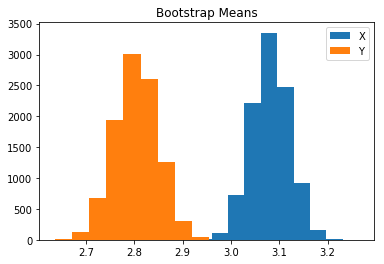

In [21]:
bootstrap(ned_goals, bel_goals, 10000)

In [22]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [23]:
#comparison NED vs SUI
t, p = stats.ttest_ind(ned_goals, sui_goals, equal_var=False)
p/2, Cohen_d(ned_goals, sui_goals)
#Null hypothesis rejected

(0.004327737916030082, 0.08731019106638802)

In [24]:
#comparison NED vs BEL
t, p = stats.ttest_ind(ned_goals, bel_goals, equal_var=False)
p/2, Cohen_d(ned_goals, bel_goals)
#Null hypothesis rejected

(1.0012208734123801e-07, 0.16258133202574165)

In [25]:
#comparison NED vs POL
t, p = stats.ttest_ind(ned_goals, pol_goals, equal_var=False)
p/2, Cohen_d(ned_goals, pol_goals)
#Null hypothesis rejected

(2.9105636507811226e-39, 0.396251804624763)

In [26]:
#comparison NED vs PRT
t, p = stats.ttest_ind(ned_goals, prt_goals, equal_var=False)
p/2, Cohen_d(ned_goals, prt_goals)
#Null hypothesis rejected

(2.680079900139088e-27, 0.32249090344988524)

In [27]:
#comparison NED vs SCT
t, p = stats.ttest_ind(ned_goals, sct_goals, equal_var=False)
p/2, Cohen_d(ned_goals, sct_goals)
#Null hypothesis rejected

(7.09162432337077e-18, 0.2630352682762722)

In [28]:
#p-value for comparison statistically significant for all comparison, Dutch league score more goals on average per match

In [29]:
#check statistics on all leagues
match_league_all = match_league[['id', 'league', 'season', 'date', 'home_team_goal', 'away_team_goal']]

In [30]:
match_league_all['total_goals'] = match_league_all['home_team_goal'] + match_league_all['away_team_goal']

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
match_league_all.groupby(['league']).describe()['total_goals']

,count,mean,std,min,25%,50%,75%,max
league,,,,,,,,
Belgium Jupiler League,1728.0,2.801505,1.656507,0.0,2.00,3.0,4.0,9.0
England Premier League,3040.0,2.710526,1.691127,0.0,1.00,3.0,4.0,10.0
France Ligue 1,3040.0,2.443092,1.551799,0.0,1.00,2.0,3.0,10.0
Germany 1. Bundesliga,2448.0,2.901552,1.704974,0.0,2.00,3.0,4.0,11.0
Italy Serie A,3017.0,2.616838,1.640327,0.0,1.00,2.0,4.0,9.0
Netherlands Eredivisie,2448.0,3.080882,1.740640,0.0,2.00,3.0,4.0,10.0
Poland Ekstraklasa,1920.0,2.425000,1.540355,0.0,1.00,2.0,3.0,8.0
Portugal Liga ZON Sagres,2052.0,2.534600,1.637348,0.0,1.00,2.0,4.0,9.0
Scotland Premier League,1824.0,2.633772,1.644379,0.0,1.00,2.0,4.0,12.0


In [32]:
epl_goals = np.array(match_league_all.loc[match_league_all['league']=='England Premier League']['total_goals'])
ger_goals = np.array(match_league_all.loc[match_league_all['league']=='Germany 1. Bundesliga']['total_goals'])
ita_goals = np.array(match_league_all.loc[match_league_all['league']=='Italy Serie A']['total_goals'])
fra_goals = np.array(match_league_all.loc[match_league_all['league']=='France Ligue 1']['total_goals'])
esp_goals = np.array(match_league_all.loc[match_league_all['league']=='Spain LIGA BBVA']['total_goals'])

In [33]:
t, p = stats.ttest_ind(ger_goals, epl_goals, equal_var=True)
t, p

(4.144430624782975, 3.457897334891059e-05)

In [34]:
t, p = stats.ttest_ind(ger_goals, esp_goals, equal_var=True)
t, p

(2.879280457539636, 0.004001259355121315)

In [35]:
t, p = stats.ttest_ind(ger_goals, ita_goals, equal_var=True)
t, p

(6.268981678097115, 3.9128632776377226e-10)

In [36]:
t, p = stats.ttest_ind(ger_goals, fra_goals, equal_var=True)
t, p

(10.409031014157865, 3.8610282774895718e-25)

In [37]:
t, p = stats.ttest_ind(epl_goals, esp_goals, equal_var=True)
t, p

(-1.2890413377191132, 0.1974327723261983)

In [38]:
t, p = stats.ttest_ind(ger_goals, ned_goals, equal_var=False)
t, p

(-3.6415305064395227, 0.0002738259530224611)

In [39]:
sum(match_league_v2.groupby('league').describe()['total_goals']['count']*
 match_league_v2.groupby('league').describe()['total_goals']['mean'])

31180.0

In [40]:
match_league_v3 = match_league.query('league_id == 1 | league_id == 13274 | league_id == 15722 \
                                  | league_id == 17642 | league_id == 19694 | league_id == 24558')

In [41]:
match_league_v3 = match_league_v3.loc[~((match_league_v3['league'] == 'Belgium Jupiler League') & 
                     (match_league_v3['season']=='2013/2014'))]

In [42]:
len(match_league_v3['home_team_api_id'].unique())

135

In [43]:
league_sum_df = match_league_v2.groupby(['league']).describe()['total_goals']

In [44]:
list(league_sum_df['mean'].index)

['Belgium Jupiler League',
 'Netherlands Eredivisie',
 'Poland Ekstraklasa',
 'Portugal Liga ZON Sagres',
 'Scotland Premier League',
 'Switzerland Super League']

In [45]:
lg = list(league_sum_df['mean'].index)
lg_abbr = ['BEL', 'NED', 'POL', 'PRT', 'SCT', 'SUI']
lg_mu = league_sum_df['mean']

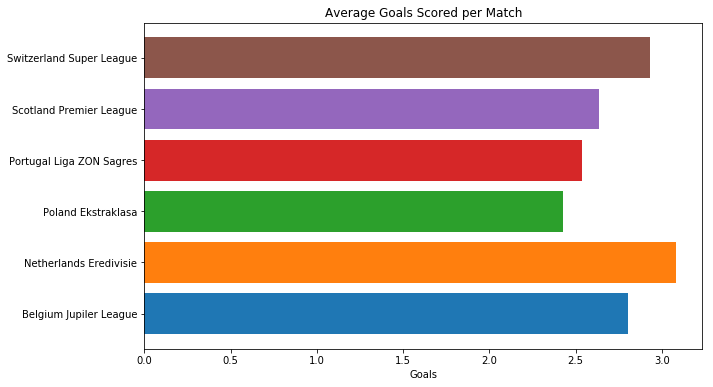

In [47]:
plt.figure(figsize=(10,6));
plt.barh(lg[0], lg_mu[0]);
plt.barh(lg[1], lg_mu[1]);
plt.barh(lg[2], lg_mu[2]);
plt.barh(lg[3], lg_mu[3]);
plt.barh(lg[4], lg_mu[4]);
plt.barh(lg[5], lg_mu[5]);
plt.title('Average Goals Scored per Match');
plt.xlabel('Goals');